In [1]:
import utils
import numpy as np
import pandas as pd
from os.path import join
from matplotlib import pyplot as plt
import matplotlib.patheffects as PathEffects
from PIL import Image
import random
from tqdm import tqdm
import pickle
from imgaug import augmenters as iaa

In [2]:
# load data
dt = utils.DirectoryTree("data/Category and Attribute Prediction Benchmark/")
with open(join(dt.Anno.path, 'meta.pickle'), 'rb' ) as f:
    data = pickle.load(f)

In [12]:
attrs = data['attr_labels']
pos = np.zeros(len(attrs[0]),)
for attr in tqdm(attrs):
    pos += np.array(attr)
pos = pos / len(attrs)
print(pos)

100%|██████████| 289222/289222 [00:20<00:00, 14105.08it/s]

[0.01120247 0.01951096 0.00042874 0.00019362 0.00018325 0.00150058
 0.00070534 0.00082981 0.00042182 0.00021091 0.00062582 0.00750634
 0.00061199 0.00044602 0.0073473  0.00599539 0.00035613 0.00184288
 0.00397273 0.00232347 0.00380331 0.0008713  0.00057741 0.00169766
 0.00288014 0.00421821 0.00067077 0.00351633 0.00077449 0.00067768
 0.00459854 0.00019017 0.00052555 0.00025932 0.00054284 0.00025586
 0.00391741 0.00076758 0.00378256 0.00205033 0.00107184 0.00095428
 0.00395544 0.00186362 0.0065002  0.0051068  0.00044257 0.00333654
 0.00596082 0.00085747 0.0093423  0.00057741 0.00022474 0.00022474
 0.00029389 0.00076758 0.00029735 0.00040108 0.00330542 0.00031464
 0.00133807 0.01237803 0.00024894 0.00032155 0.00020054 0.00030426
 0.00051863 0.00022128 0.00168383 0.00069151 0.00427008 0.00053938
 0.00214714 0.00207799 0.00106147 0.00019362 0.00111679 0.00149712
 0.00047714 0.00032847 0.00156627 0.02219402 0.00124126 0.00735421
 0.00177718 0.00100269 0.00031464 0.00577065 0.000204   0.0002

In [101]:
data.keys()

dict_keys(['img_names', 'cat_labels', 'attr_labels', 'cat_index', 'attr_index', 'bbox_coords', 'eval_status'])

Number of images in 50 categories : 289222


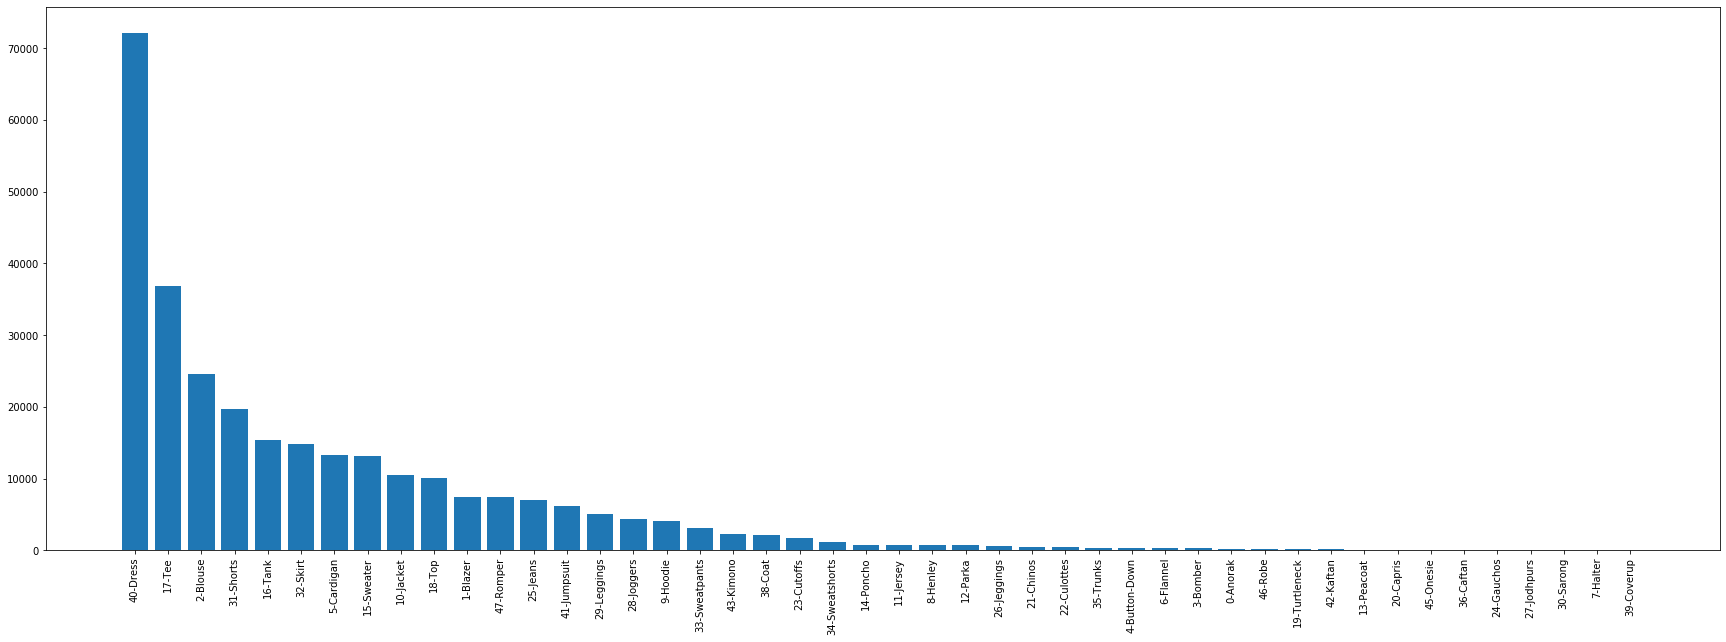

In [104]:
# Plot categories with highest number of occurrence 
top_k = 50
unique, counts = np.unique(data['cat_labels'], return_counts= True)
unique = np.array(list(map(lambda key: "%i-%s"%(key, data['cat_index'][str(key)]), unique)))
index = np.argsort(counts)[::-1]
index = index[:top_k]
top_k_counts = counts[index]
top_k_unique = unique[index]
print("Number of images in %i categories : %i"%(top_k, sum(top_k_counts)))
plt.figure(figsize = (30, 10))
plt.bar(list(range(len(top_k_unique))), top_k_counts)
plt.xticks(list(range(len(top_k_unique))), list(top_k_unique), rotation = 90)
plt.show()

In [103]:
np.array(data['attr_labels'])

KeyboardInterrupt: 

In [105]:
# Plot most common attributes among categories
cats = ('Dress', 'Tee', 'Blouse', 'Shorts', 'Tank', 'Skirt', 'Cardigan', 'Jacket', 'Top', 'Blazer')
cat_ids = (40, 17, 2, 31, 16, 32, 5, 15, 10, 18, 1)
index = np.arange(len(data['cat_labels']))
attr_dict = {}
for i, (c, cid) in tqdm(enumerate(zip(cats, cat_ids))):
    attrs = np.array([data['attr_labels'][j] for j in range(len(data['cat_labels'])) if data['cat_labels'][j] == cid])
    attr_dict[c] = attrs

10it [00:16,  1.62s/it]


In [117]:
print(attrs.shape)

(72158, 1000)


10it [00:00, 18.81it/s]


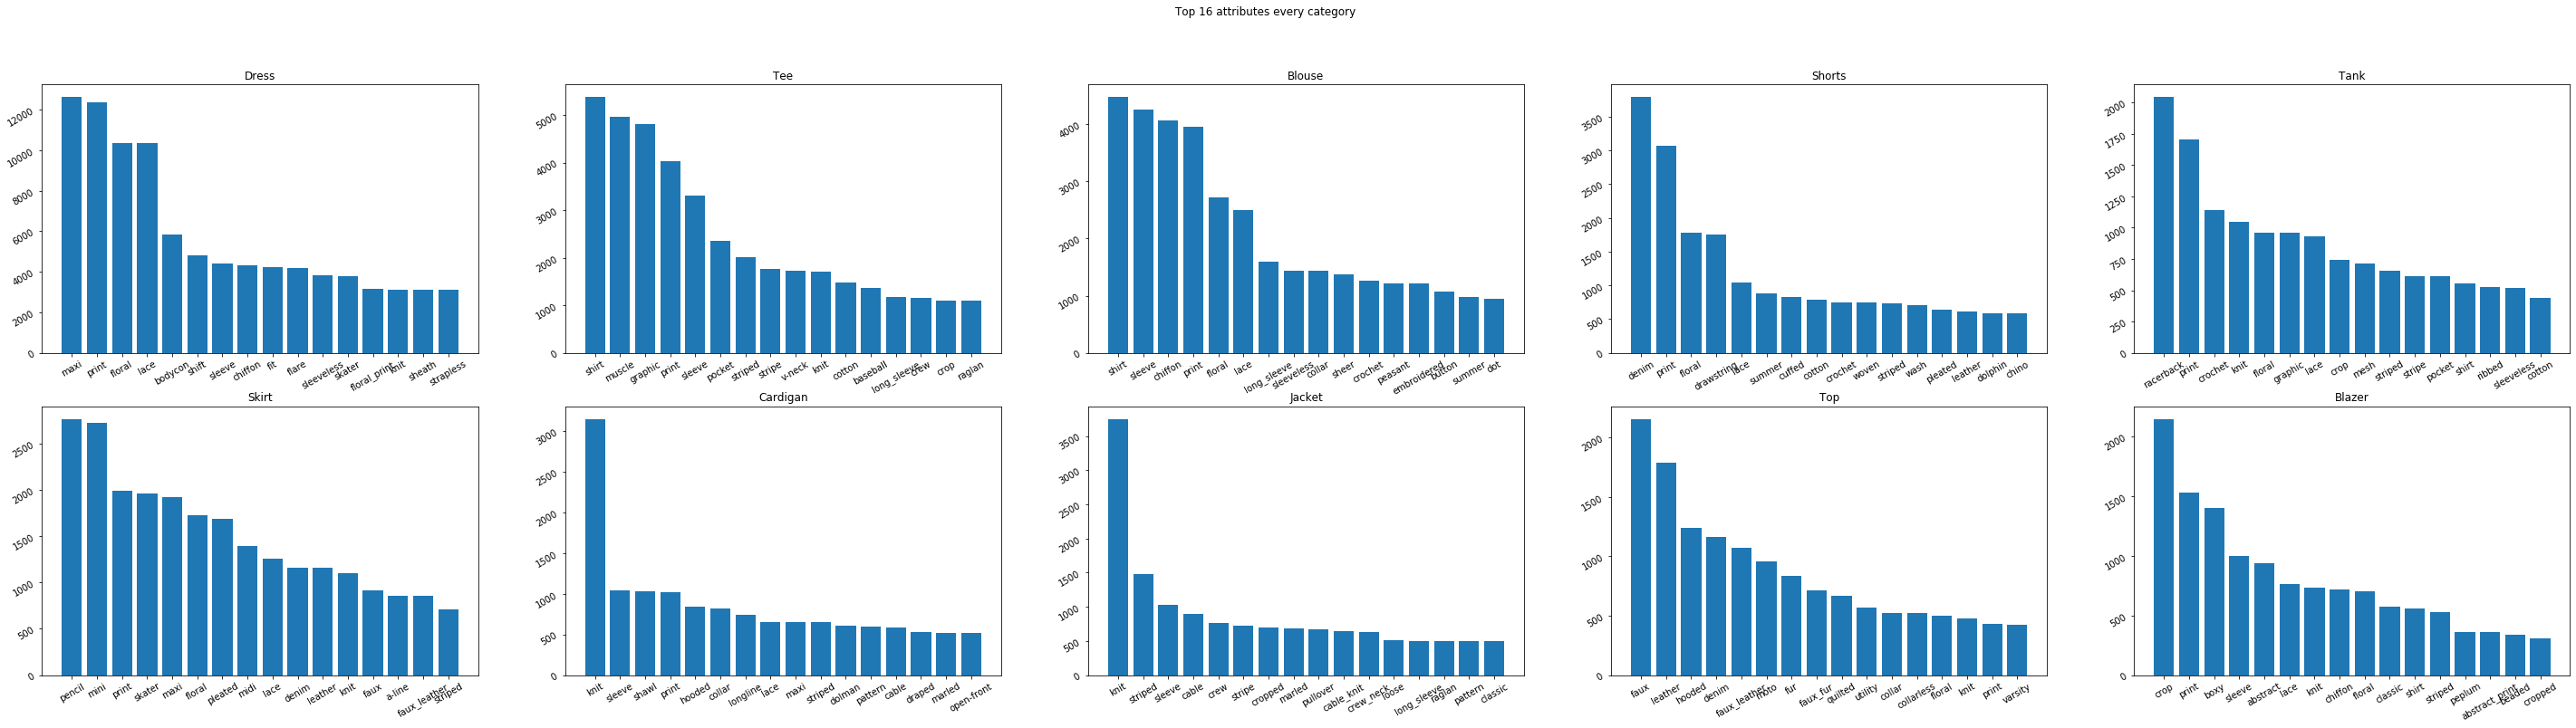

In [130]:
k = 16
fig, axes = plt.subplots(2, 5, figsize = (50, 12))
axes = axes.flatten()
for i, (cat, attrs) in tqdm(enumerate(attr_dict.items())):
    attr_count = np.sum(attrs, axis = 0)
    index = np.argsort(attr_count)[::-1][:k]
    arr = np.array([[attr_count[j], data['attr_index'][str(j)]] for j in index])
    counts, names = np.squeeze(arr[:, 0]), np.squeeze(arr[:, 1])
    axes[i].bar(list(range(len(names))), list(map(int, counts)))
    axes[i].set_xticks(list(range(len(names))))
    axes[i].set_xticklabels(names)
    axes[i].tick_params(rotation = 30)
    axes[i].set_title("%s"%cat)
fig.suptitle("Top %i attributes every category"%k)
plt.show()    

In [69]:
def plot_images(images, k = 16):
    if k == 16:
        fig, axes = plt.subplots(4, 4, figsize = (20, 20))
    elif k == 36:
        fig, axes = plt.subplots(6, 6, figsize = (20, 20))
    else:
        fig, axes = plt.subplots(8, 8, figsize = (20, 20))
    axes = axes.flatten()
    for i in range(k):
        axes[i].imshow(images[i])
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    plt.show()

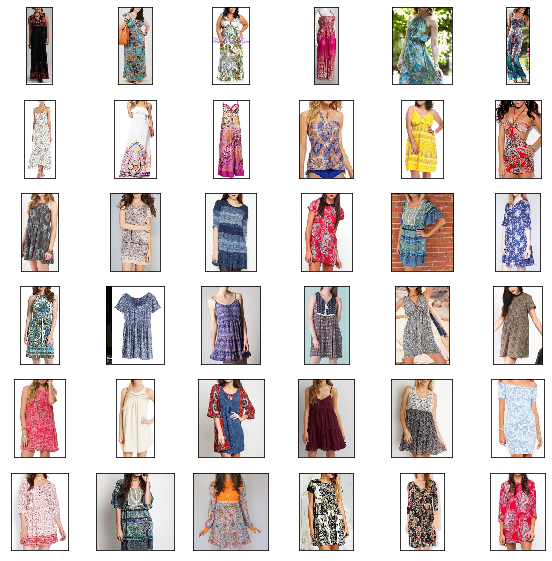

In [65]:
# Crop and visualize images
k = 36
img_paths = list(map(lambda path: join(dt.Img.path, path), data['img_names'][-k:]))
bboxes = data['bbox_coords'][-k:]
images = []
for i in range(k):
    bbox = [bboxes[i][0], bboxes[i][2], bboxes[i][1], bboxes[i][3]] # (x1, y1, x2, y2)
    img = Image.open(img_paths[i])
    img = img.crop(bbox)
    images.append(img)

plot_images(images, k = 36)

In [93]:
def aug_pipeline(p = 0.2):
    # Augmentors by https://github.com/aleju/imgaug

    # Helper Lambda
    sometimes = lambda aug: iaa.Sometimes(p, aug)

    aug_pipe = iaa.Sequential(
        [
            iaa.SomeOf(
                (1, 2),
                [
                    sometimes(iaa.Fliplr(1.)),  # horizontally flip 50% of all images
                    sometimes(iaa.Crop(percent=(0, 0.15))),  # crop images by 0-10% of their height/width
                    sometimes(iaa.Affine(translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}))
                ]
            ),
            iaa.SomeOf(
                (0, 2),
                [
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.04 * 255), per_channel=0.5),
                ],
                random_order=True  # The procedures will be used in random order
            )
        ],
        random_order=True
    )

    return aug_pipe

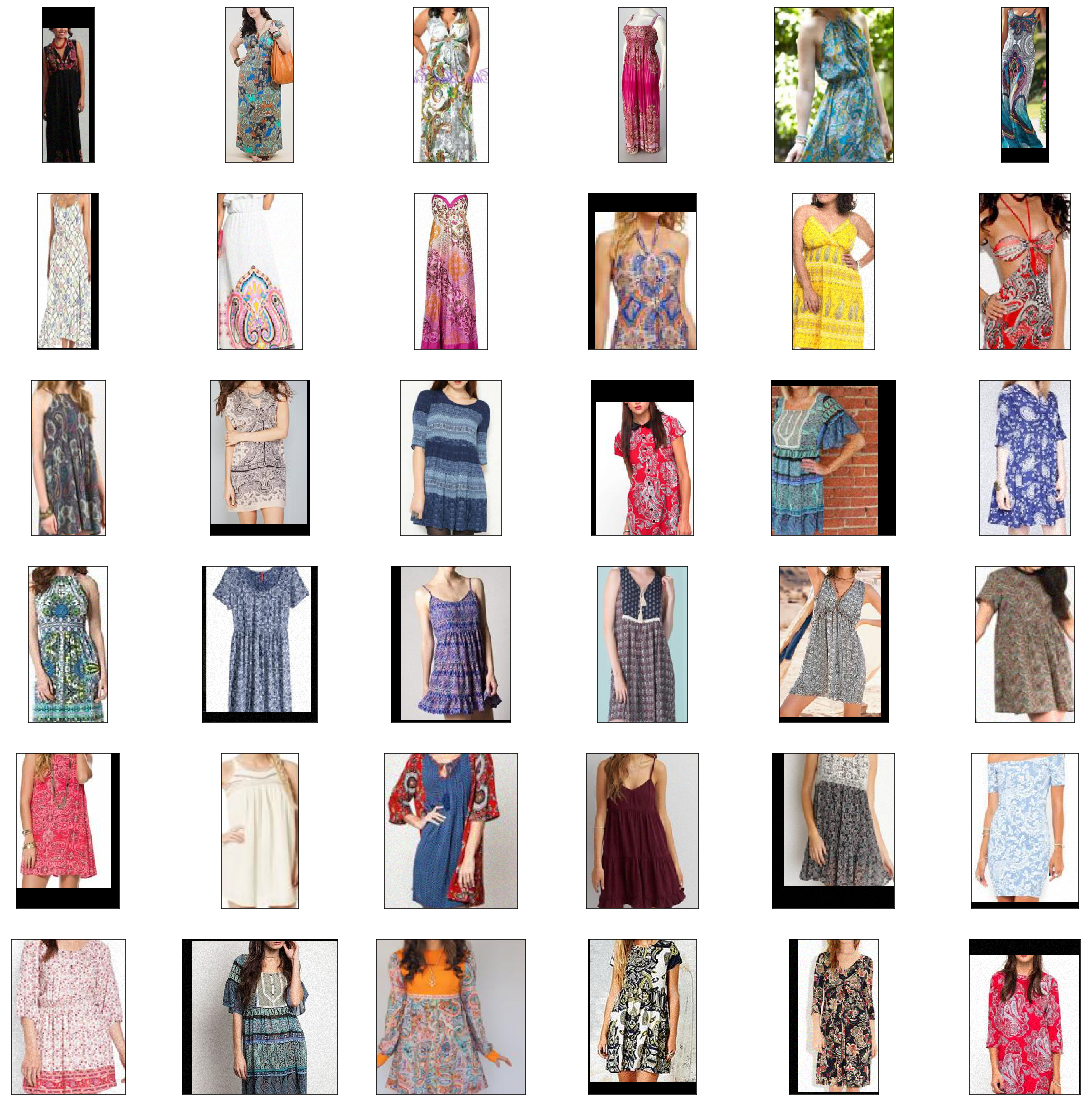

In [94]:
aug_images = []
aug_pipe = aug_pipeline(p = 1.)
for i in range(k):
    np_img = np.array(images[i])
    aug_images.append(aug_pipe.augment_image(np_img))
plot_images(aug_images, k = 36)

In [126]:
from tensorflow import keras

In [132]:
mobil = keras.applications.mobilenet.MobileNet(input_shape=(256, 256, 3), include_top=False, weights='imagenet', pooling='avg')
x = mobil.outputs[0]
cat = keras.layers.Dense(50, name='categories', activation='softmax')(x)
attr = keras.layers.Dense(1000, name='attributes', activation='sigmoid')(x)
model = keras.models.Model(inputs = mobil.inputs[0], outputs = [cat, attr])

/home/yoelmolinas/.conda/envs/cpu/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [140]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________